# MPI validation
Comparison between MPI climate model and ORAS5

## Imports

In [1]:
import warnings
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import xarray as xr
import tqdm
import pathlib
import cmocean
import pandas as pd
import os

# Import custom modules
from src.XRO import XRO, xcorr
import src.utils

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])
SAVE_FP = pathlib.Path(os.environ["SAVE_FP"])

## Load data

In [2]:
## MPI data
mpi_load_fp = pathlib.Path(DATA_FP, "mpi_Th", "Th.nc")
Th_mpi = xr.open_dataset(mpi_load_fp)

## ORAS5 reanalysis (use as benchmark)
oras_load_fp = pathlib.Path(DATA_FP, "XRO_indices_oras5.nc")
Th_oras = xr.open_dataset(oras_load_fp)

## rename variables for consistency and trim so time periods covered are the same
Th_mpi = Th_mpi.sel(time=slice("1979", "2024"))
Th_oras = Th_oras[["Nino34", "WWV"]].rename({"Nino34": "T_34", "WWV": "h"})

## Diagnostics

### Seasonal synchronization

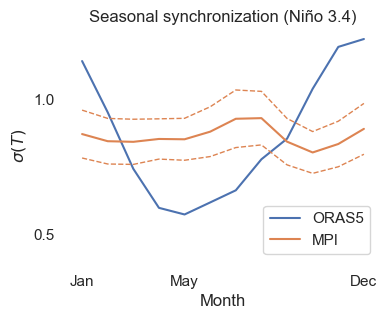

In [3]:
## specify which "T" variable to use for MPI
T_var_mpi = "T_3"

## func to compute std dev as a function of month
get_std = lambda x: x.groupby("time.month").std("time")

## compute std for each dataset
oras_std = get_std(Th_oras["T_34"])
mpi_std = get_std(Th_mpi[T_var_mpi])
mpi_std_plot = src.utils.get_ensemble_stats(mpi_std)

## months (x-coordinate for plotting
months = np.arange(1, 13)

### Set up plot
fig, ax = plt.subplots(figsize=(4, 3))

## plot for ORAS5
oras_plot = ax.plot(months, oras_std, label="ORAS5")

## plot MPI ensemble mean
mpi_plot = ax.plot(months, mpi_std_plot.sel(posn="center"), label="MPI")

## plot MPI bounds
kwargs = dict(c=mpi_plot[0].get_color(), ls="--", lw=1)
for bound in ["upper", "lower"]:
    ax.plot(months, mpi_std_plot.sel(posn=bound), **kwargs)

## adjust limits and label
ax.set_ylim([0.4, None])
ax.set_yticks([0.5, 1])
ax.set_xticks([1, 5, 12], labels=["Jan", "May", "Dec"])
ax.set_xlabel("Month")
ax.set_ylabel(f"$\\sigma(T)$")
ax.set_title("Seasonal synchronization (Niño 3.4)")
ax.legend()
plt.show()

### $T,h$ cross-correlation

Plotting funcs

In [4]:
def format_axs(axs):
    ## add axis lines to plots
    axis_kwargs = dict(c="k", lw=0.5, alpha=0.5)
    for ax in axs.flatten():
        ax.axhline(0, **axis_kwargs)
        ax.axvline(0, **axis_kwargs)
        ax.set_ylim([-0.7, 1.1])

    #### label plots

    ## bottom row
    for ax in axs[1]:
        ax.set_xlabel("Lag (years)")
        ax.set_xticks([-12, 0, 12], labels=[-1, 0, 1])

    ## top row
    for ax in axs[0]:
        ax.set_xticks([])

    ## left col
    for ax in axs[:, 0]:
        ax.set_ylabel("Correlation")

    ## right col
    for ax in axs[:, 1]:
        ax.set_yticks([])

    return axs


def plot_oras(ax, data, color, label=None):
    """Plot curve for oras"""

    ax.plot(data.lag, data, c=color, label=label, ls="--")

    return


def plot_mpi(ax, data, color, label=None):
    """plot mean and bounds for MPI"""

    ## center
    ax.plot(
        data.lag,
        data.sel(posn="center"),
        c=color,
        label=label,
    )

    ## bounds
    ax.fill_between(
        data.lag, data.sel(posn="upper"), data.sel(posn="lower"), color=color, alpha=0.2
    )

    return

Compute stats

In [5]:
## specify which "T" variable to use for MPI
T_var_mpi = "T_3"
h_var_mpi = "h_w"

## compute cross-correlation
xcorr_oras = xcorr(Th_oras, Th_oras["T_34"], maxlags=18)
xcorr_mpi = xcorr(Th_mpi, Th_mpi[T_var_mpi], maxlags=18)

## compute MPI stats
xcorr_mpi_stats = src.utils.get_ensemble_stats(xcorr_mpi)

Make plot

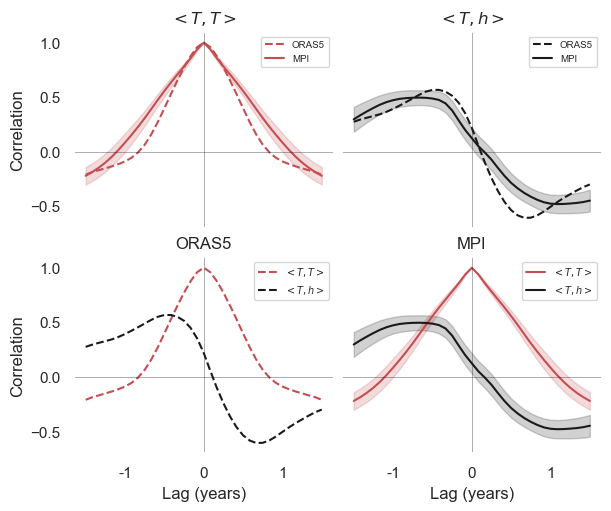

In [6]:
## specify plot properties for legend
legend_prop = dict(size=7)

fig, axs = plt.subplots(2, 2, figsize=(6, 5), layout="constrained")

## plot <T,T>
axs[0, 0].set_title(r"$<T, T>$")
plot_oras(axs[0, 0], xcorr_oras["T_34"], color="r", label="ORAS5")
plot_mpi(axs[0, 0], xcorr_mpi_stats[T_var_mpi], color="r", label="MPI")

## plot <T,h>
axs[0, 1].set_title(r"$<T, h>$")
plot_oras(axs[0, 1], xcorr_oras["h"], color="k", label="ORAS5")
plot_mpi(axs[0, 1], xcorr_mpi_stats[h_var_mpi], color="k", label="MPI")

## plot for ORAS5
axs[1, 0].set_title("ORAS5")
plot_oras(axs[1, 0], xcorr_oras["T_34"], color="r", label="$<T, T>$")
plot_oras(axs[1, 0], xcorr_oras["h"], color="k", label="$<T, h>$")

## plot for MPI
axs[1, 1].set_title("MPI")
plot_mpi(axs[1, 1], xcorr_mpi_stats[T_var_mpi], color="r", label="$<T, T>$")
plot_mpi(axs[1, 1], xcorr_mpi_stats[h_var_mpi], color="k", label="$<T, h>$")

## clean up axes
axs = format_axs(axs)

for ax in axs.flatten():
    ax.legend(prop=dict(size=7))

plt.show()

## RO-based diagnostics
Note: need to non-dimensionalize $T$ and $h$ data to compare $F_1$ and $F_2$ parameters to each other and to $R$ and $\epsilon$

In [7]:
## get non-dimensional scale for each variable (specific to each dataset)
scale_oras = Th_oras.std()
scale_mpi = Th_mpi.std()

## non-dimensionalize
Th_oras_nondim = Th_oras / scale_oras
Th_mpi_nondim = Th_mpi / scale_mpi

In [8]:
def plot_param_ensemble(ax, param, label=None):
    """plot ensemble of parameters on given ax object"""

    ## specify plot style for ensemble mean v. members
    mean_kwargs = dict(c="k", lw=3, label=label)
    mem_kwargs = dict(c="k", lw=0.5, alpha=0.2)

    ## plot ensemble mean
    ax.plot(param.cycle, param.mean("member"), **mean_kwargs)

    ## plot individual members
    for m in param.member:
        ax.plot(param.cycle, param.sel(member=m), **mem_kwargs)

    return


def plot_param(ax, param, **plot_kwargs):
    """plot parameter on given ax object"""

    ax.plot(param.cycle, param, **plot_kwargs)


def label_ac_ax(ax):
    """add labels to growth rate annual cycle plot (ax object)"""

    ax.set_ylabel(r"Growth rate (yr$^{-1}$)")
    ax.axhline(0, c="k", ls="-", lw=0.5)
    ax.set_xticks([1, 8, 12], labels=["Jan", "Aug", "Dec"])

    return

### Growth rate / periodicity

Do the computation

In [12]:
## specify T and h variables to use for MPI
T_var_mpi = "T_3"
h_var_mpi = "h_w"

## specify order of annual cycle
ac_order = 3

## specify which parameters to mask annual cycle out for [(y_idx0, x_idx0), ...]
# ac_mask_idx = [(1,1)]
ac_mask_idx = None

## initialize model
model = XRO(ncycle=12, ac_order=ac_order, is_forward=True)

## get fit for reanalysis
fit_oras = model.fit_matrix(Th_oras_nondim[["T_34", "h"]], ac_mask_idx=ac_mask_idx)

## get fit for MPI (ensemble-of-RO method)
_, fit_mpi = src.utils.get_RO_ensemble(
    Th_mpi_nondim,
    model=model,
    T_var=T_var_mpi,
    h_var=h_var_mpi,
    ac_mask_idx=ac_mask_idx,
)

## get fit for MPI (ensemble fit)
fit_mpi_all = model.fit_matrix(
    Th_mpi_nondim[[T_var_mpi, h_var_mpi]], ac_mask_idx=ac_mask_idx
)

## compute timescales for each
bj_oras, period_oras = src.utils.get_timescales(model, fit_oras)
bj_mpi, period_mpi = src.utils.get_timescales_ensemble(model, fit_mpi)
bj_mpi_all, period_mpi_all = src.utils.get_timescales(model, fit_mpi_all)

## get PDF for period
pdf, edges = src.utils.get_empirical_pdf(period_mpi, edges=np.arange(3, 19))

/Users/theo/research/enso2025_xro/envs/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)
/Users/theo/research/enso2025_xro/envs/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)
/Users/theo/research/enso2025_xro/envs/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)
/Users/theo/research/enso2025_xro/envs/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


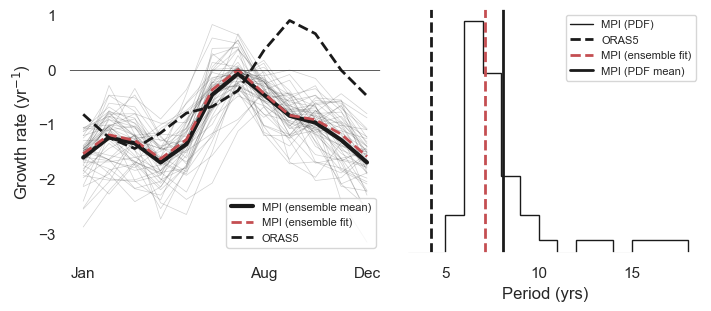

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3), layout="constrained")

### plot seasonal cycle of growth rate
# MPI: ensemble and ensemble mean
plot_param_ensemble(axs[0], bj_mpi, label="MPI (ensemble mean)")

# MPI: fit to all ensemble members
plot_kwargs = dict(c="r", ls="--", lw=2, label="MPI (ensemble fit)")
plot_param(axs[0], bj_mpi_all, **plot_kwargs)

# ORAS5
plot_kwargs = dict(c="k", ls="--", lw=2, label="ORAS5")
plot_param(axs[0], bj_oras, **plot_kwargs)
axs[0].legend(prop=dict(size=8))

## label axes
label_ac_ax(axs[0])

## plot period
axs[1].stairs(pdf, edges, color="k", label="MPI (PDF)")
axs[1].axvline(period_oras, c="k", ls="--", lw=2, label="ORAS5")
axs[1].axvline(period_mpi_all, c="r", ls="--", lw=2, label="MPI (ensemble fit)")
axs[1].axvline(period_mpi.mean(), c="k", lw=2, label="MPI (PDF mean)")
axs[1].set_xlim([2, None])
axs[1].set_yticks([])
axs[1].set_xlabel("Period (yrs)")
axs[1].legend(prop=dict(size=8))

plt.show()

### Parameters

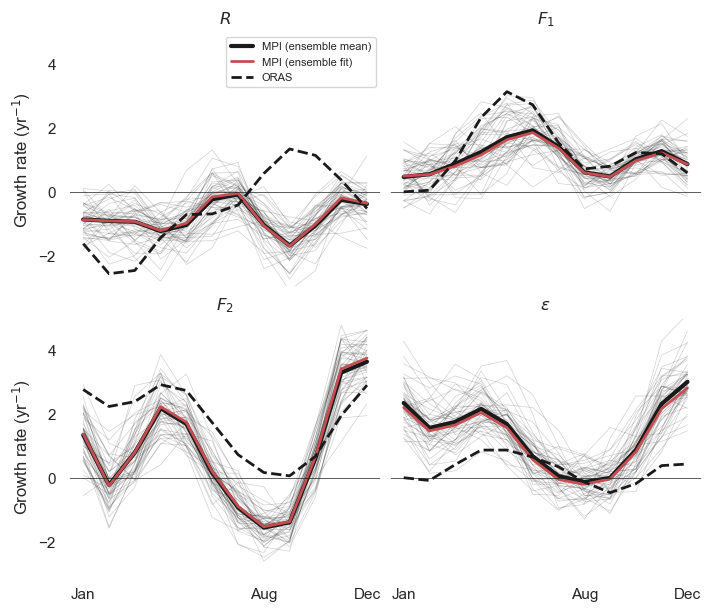

In [14]:
## Get parameters for ORAS and MPI
params_oras = model.get_RO_parameters(fit_oras)
params_mpi = model.get_RO_parameters(fit_mpi)
params_mpi_all = model.get_RO_parameters(fit_mpi_all)

## get labels of parameters for plotting
labels = [r"$R$", r"$F_1$", r"$F_2$", r"$\epsilon$"]
var_names = ["R", "F1", "F2", "epsilon"]

## set up plot
fig, axs = plt.subplots(2, 2, figsize=(7, 6), layout="constrained")

## separate plo for each set of parameters
for i, (ax, label, n) in enumerate(zip(axs.flatten(), labels, var_names)):

    ### plot seasonal cycle parameter for each
    plot_param_ensemble(ax, params_mpi[n], label="MPI (ensemble mean)")
    plot_param(ax, params_mpi_all[n], c="r", lw=2, label="MPI (ensemble fit)")
    plot_param(ax, params_oras[n], c="k", ls="--", lw=2, label="ORAS")
    ax.set_title(label)
    ax.set_ylim([-3, 5])
    label_ac_ax(ax)

## make plot less clustered
for ax in axs[0, :]:
    ax.set_xlabel(None)
    ax.set_xticks([])
for ax in axs[:, 1]:
    ax.set_ylabel(None)
    ax.set_yticks([])
for ax in axs[:, 0]:
    ax.set_yticks([-2, 0, 2, 4])

axs[0, 0].legend(prop=dict(size=8))
plt.show()

### Plot parameter uncertainty

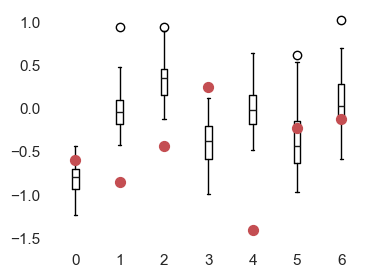

In [12]:
## coordinates to select "R" parameter
R_idx = dict(rankx=0, ranky=0)
N = len(fit_mpi.member)

fig, ax = plt.subplots(figsize=(4, 3))
for j in fit_oras.Lcoef.cossin:
    ax.scatter(j, fit_oras.Lcoef.isel(**R_idx, cossin=j), zorder=10, s=50, c="r")
    ax.boxplot(
        fit_mpi.Lcoef.isel(**R_idx, cossin=j),
        positions=[j],
        medianprops=dict(color="k"),
    )

ax.set_ylim([None, None])

plt.show()